## Modifying Data to be Usable

In [1]:
import pandas as pd
Ecsv=pd.read_csv('Edata.csv') 
Icsv=pd.read_csv('Idata.csv') 
EIcsv=pd.concat([Ecsv,Icsv])
rowInd=pd.Series(range(len(EIcsv)))
EIcsv=EIcsv.set_index(rowInd)
EIcsv=EIcsv.drop(['Unnamed: 0'],axis=1)
labels=EIcsv.iloc[:,0]
comments=EIcsv.iloc[:,1]
comments=pd.Series(comments) #count-vectorizer cannot understand dataframes, but can with series
print('# of introvert comments are',Icsv.shape[0])
print('# of extrovert comments are',Ecsv.shape[0])

# of introvert comments are 3761
# of extrovert comments are 2774


### Bag of Words

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
countvec=CountVectorizer(analyzer='word',stop_words='english',max_features=2500) #create wordfreq-matrix with dim=2500
SpComments=countvec.fit_transform(comments)
print('Shapes of word frequency matrix:',SpComments.shape)

Shapes of word frequency matrix: (6535, 2500)


### PCA(via Latent Semantic Analysis)

In [3]:
from sklearn.decomposition import TruncatedSVD
LSA=TruncatedSVD(n_components=100) #we choose 100 principal components
LSA=LSA.fit_transform(SpComments)
print('Shape of LSA matrix:',LSA.shape)

Shape of LSA matrix: (6535, 100)


### Initializations

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import seaborn as sns       

## initialize models
logreg=LogisticRegression(class_weight='balanced',solver='liblinear')
linsvm=LinearSVC(class_weight='balanced')
neigh = KNeighborsClassifier(n_neighbors=3)

##lists to loop over 
datasets=[SpComments,LSA]
trials=[1,2,3]
splits=[0.8,0.5,0.2]


### Logistic Regression

0.02230875031552168


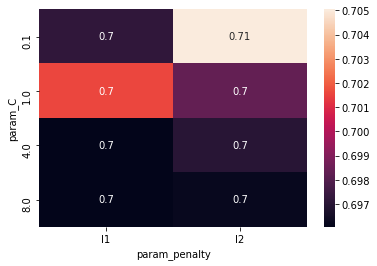

In [5]:
logreg_grid=dict(C=[0.1,1,4,8],penalty=['l2', 'l1'])
test_scores=[]
valid_scores=[]
train_scores=[]
for data in datasets:
    for trial in trials:
        for split in splits:    
            train_comments, test_comments= train_test_split(data,test_size=split,random_state=trial)
            train_labels, test_labels = train_test_split(labels,test_size=split,random_state=trial)
            trainMod=logreg.fit(train_comments,train_labels) #train logreg without cv
            TrainScore=trainMod.score(train_comments,train_labels)
            train_scores.append(TrainScore)
            GrdSrch = GridSearchCV(logreg, logreg_grid,cv=5,n_jobs=6) #cross-validate
            tuned=GrdSrch.fit(train_comments,train_labels)
            valid_scores.append(max(tuned.cv_results_['mean_test_score']))
            BestParams =tuned.best_params_
            TrainTuned=logreg.set_params(**BestParams)  #train logreg using tuned parameters from cv(with 60)
            TrainTuned.fit(train_comments,train_labels)
            pred_labels=TrainTuned.predict(test_comments)  #test logreg using tuned parameters 
            test_scores.append(accuracy_score(test_labels,pred_labels))
from statistics import mean
logregVar=mean(tuned.cv_results_['std_test_score'])
print(logregVar)
LogRegpvt = pd.pivot_table(pd.DataFrame(GrdSrch.cv_results_),
                     values='mean_test_score', index='param_C', columns='param_penalty')
LogRegHM = sns.heatmap(LogRegpvt,annot=True)




In [6]:
from statistics import mean
sparseTrAvgs=[mean(train_scores[0:3]),mean(train_scores[3:6]),mean(train_scores[6:9])]
sparseValAvgs=[mean(valid_scores[0:3]),mean(valid_scores[3:6]),mean(valid_scores[6:9])]
sparseTeAvgs=[mean(test_scores[0:3]),mean(test_scores[3:6]),mean(test_scores[6:9])]
LSATrAvgs=[mean(train_scores[9:12]),mean(train_scores[12:15]),mean(train_scores[15:18])]
LSAValAvgs=LSATrAvgs=[mean(train_scores[9:12]),mean(train_scores[12:15]),mean(train_scores[15:18])]
LSATeAvgs=[mean(test_scores[9:12]),mean(test_scores[12:15]),mean(test_scores[15:18])]
LogRegSAvgs=pd.DataFrame(list(zip(sparseTrAvgs,sparseValAvgs,sparseTeAvgs)),index=['.8','0.5','0.2'],columns=['Training','Validation'
                                                                                                      ,'Test'])
LogRegLSAAvgs=pd.DataFrame(list(zip(LSATrAvgs,LSAValAvgs,LSATeAvgs)),index=['.8','0.5','0.2'],columns=['Training','Validation'
                                                                                                      ,'Test'])
print(LogRegSAvgs)
print(LogRegLSAAvgs)
## 2 datasets, 3 partitions, 3 trials is 18 scores per type of score
#scores 0-9: SpComments, scores 10-18: LSA

TrAvgs=[mean(train_scores[0:9]),mean(train_scores[10:18])]
ValAvgs=[mean(valid_scores[0:9]),mean(valid_scores[10:18])]
TestAvgs=[mean(test_scores[0:9]),mean(test_scores[10:18])]

LogRegAvgs=pd.DataFrame(list(zip(TrAvgs,ValAvgs,TestAvgs)),index=['Sparse','LSA'],columns=['Train','Validation','Test'])
print(LogRegAvgs)

     Training  Validation      Test
.8   0.842160    0.700238  0.728374
0.5  0.819463    0.721559  0.709056
0.2  0.809248    0.710591  0.724103
     Training  Validation      Test
.8   0.718450    0.718450  0.705498
0.5  0.732363    0.732363  0.696598
0.2  0.725464    0.725464  0.701354
           Train  Validation      Test
Sparse  0.823624    0.710796  0.720511
LSA     0.726395    0.703198  0.702528


## K-Nearest Neighbors

0.014874996545139617


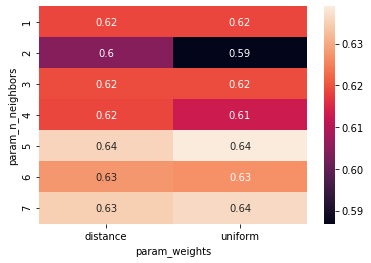

In [7]:
neigh_grid = {'n_neighbors': np.arange(1, 8), 'weights': ['uniform','distance']}
test_scores=[]
valid_scores=[]
train_scores=[]
for data in datasets:
    for trial in trials:
        for split in splits:    
            train_comments, test_comments= train_test_split(data,test_size=split,random_state=trial)
            train_labels, test_labels = train_test_split(labels,test_size=split,random_state=trial)
            trainMod=neigh.fit(train_comments,train_labels) #train neigh without cv
            TrainScore=trainMod.score(train_comments,train_labels)
            train_scores.append(TrainScore)
            GrdSrch = GridSearchCV(neigh, neigh_grid,cv=5,n_jobs=6) #cross-validate
            tuned=GrdSrch.fit(train_comments,train_labels)
            valid_scores.append(max(tuned.cv_results_['mean_test_score']))
            BestParams =tuned.best_params_
            TrainTuned=neigh.set_params(**BestParams)  #train neigh using tuned parameters from cv
            TrainTuned.fit(train_comments,train_labels)
            pred_labels=TrainTuned.predict(test_comments)  #test neigh using tuned parameters 
            test_scores.append(accuracy_score(test_labels,pred_labels))
KNNVar=mean(tuned.cv_results_['std_test_score'])
print(KNNVar)
KNNpvt = pd.pivot_table(pd.DataFrame(GrdSrch.cv_results_),
                     values='mean_test_score', index='param_n_neighbors', columns='param_weights')
KNNHM = sns.heatmap(KNNpvt,annot=True)

In [8]:
sparseTrAvgs=[mean(train_scores[0:3]),mean(train_scores[3:6]),mean(train_scores[6:9])]
sparseValAvgs=[mean(valid_scores[0:3]),mean(valid_scores[3:6]),mean(valid_scores[6:9])]
sparseTeAvgs=[mean(test_scores[0:3]),mean(test_scores[3:6]),mean(test_scores[6:9])]
LSATrAvgs=[mean(train_scores[9:12]),mean(train_scores[12:15]),mean(train_scores[15:18])]
LSAValAvgs=LSATrAvgs=[mean(train_scores[9:12]),mean(train_scores[12:15]),mean(train_scores[15:18])]
LSATeAvgs=[mean(test_scores[9:12]),mean(test_scores[12:15]),mean(test_scores[15:18])]

KNNSAvgs=pd.DataFrame(list(zip(sparseTrAvgs,sparseValAvgs,sparseTeAvgs)),index=['.8','0.5','0.2'],columns=['Training','Validation'
                                                                                                      ,'Test'])
KNNLSAAvgs=pd.DataFrame(list(zip(LSATrAvgs,LSAValAvgs,LSATeAvgs)),index=['.8','0.5','0.2'],columns=['Training','Validation'
                                                                                                      ,'Test'])

print(KNNSAvgs)
print(KNNLSAAvgs)
## 2 datasets, 3 partitions, 3 trials is 18 scores per type of score
#scores 0-9: SpComments, scores 10-18: LSA

TrAvgs=[mean(train_scores[0:9]),mean(train_scores[10:18])]
ValAvgs=[mean(valid_scores[0:9]),mean(valid_scores[10:18])]
TestAvgs=[mean(test_scores[0:9]),mean(test_scores[10:18])]

KNNAvgs=pd.DataFrame(list(zip(TrAvgs,ValAvgs,TestAvgs)),index=['Sparse','LSA'],columns=['Train','Validation','Test'])
print(KNNAvgs)

     Training  Validation      Test
.8   0.755626    0.626614  0.629769
0.5  0.847389    0.627549  0.610911
0.2  0.734240    0.625451  0.627639
     Training  Validation      Test
.8   0.797792    0.797792  0.642992
0.5  0.724406    0.724406  0.632537
0.2  0.724277    0.724277  0.619288
           Train  Validation      Test
Sparse  0.779085    0.626538  0.622773
LSA     0.753484    0.638236  0.631893


## Support Vector Machine

In [9]:
linsvm_grid=dict(C=[.01,0.5,1,4,10]) 
test_scores=[]
valid_scores=[]
train_scores=[]
for data in datasets:
    for trial in trials:
        for split in splits:    
            train_comments, test_comments= train_test_split(data,test_size=split,random_state=trial)
            train_labels, test_labels = train_test_split(labels,test_size=split,random_state=trial)
            trainMod=linsvm.fit(train_comments,train_labels) #train linsvm without cv
            TrainScore=trainMod.score(train_comments,train_labels)
            train_scores.append(TrainScore)
            GrdSrch = GridSearchCV(linsvm, linsvm_grid,cv=5,n_jobs=6) #cross-validate with 4 param-iterations
            tuned=GrdSrch.fit(train_comments,train_labels)
            valid_scores.append(max(tuned.cv_results_['mean_test_score']))
            BestParams =tuned.best_params_
            TrainTuned=linsvm.set_params(**BestParams)  #train linsvm using tuned parameters from cv
            TrainTuned.fit(train_comments,train_labels)
            pred_labels=TrainTuned.predict(test_comments)  #test linsvm using tuned parameters 
            test_scores.append(accuracy_score(test_labels,pred_labels))

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.020358878804925255
     Training  Validation      Test
.8   0.852438    0.701911  0.725620
0.5  0.814655    0.722626  0.708457
0.2  0.804810    0.709422  0.720825
     Training  Validation      Test
.8   0.715377    0.715377  0.699136
0.5  0.731407    0.731407  0.695451
0.2  0.722455    0.722455  0.700780
           Train  Validation      Test
Sparse  0.823968    0.711320  0.718301
LSA     0.724616    0.701783  0.699855


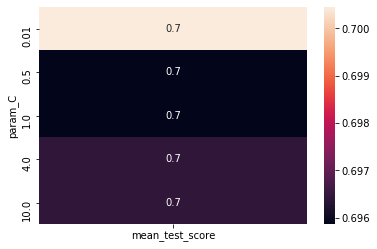

In [10]:
SVMVar=mean(tuned.cv_results_['std_test_score'])
print(SVMVar)
linsvmpvt = pd.pivot_table(pd.DataFrame(GrdSrch.cv_results_),
         values='mean_test_score', index='param_C')
linsvmHM = sns.heatmap(linsvmpvt,annot=True)

sparseTrAvgs=[mean(train_scores[0:3]),mean(train_scores[3:6]),mean(train_scores[6:9])]
sparseValAvgs=[mean(valid_scores[0:3]),mean(valid_scores[3:6]),mean(valid_scores[6:9])]
sparseTeAvgs=[mean(test_scores[0:3]),mean(test_scores[3:6]),mean(test_scores[6:9])]
LSATrAvgs=[mean(train_scores[9:12]),mean(train_scores[12:15]),mean(train_scores[15:18])]
LSAValAvgs=LSATrAvgs=[mean(train_scores[9:12]),mean(train_scores[12:15]),mean(train_scores[15:18])]
LSATeAvgs=[mean(test_scores[9:12]),mean(test_scores[12:15]),mean(test_scores[15:18])]

SVMSAvgs=pd.DataFrame(list(zip(sparseTrAvgs,sparseValAvgs,sparseTeAvgs)),index=['.8','0.5','0.2'],columns=['Training','Validation'
                                                                                                      ,'Test'])
SVMLSAAvgs=pd.DataFrame(list(zip(LSATrAvgs,LSAValAvgs,LSATeAvgs)),index=['.8','0.5','0.2'],columns=['Training','Validation'
                                                                                                      ,'Test'])
print(SVMSAvgs)
print(SVMLSAAvgs)
## 2 datasets, 3 partitions, 3 trials is 18 scores per type of score
#scores 0-9: SpComments, scores 10-18: LSA

TrAvgs=[mean(train_scores[0:9]),mean(train_scores[10:18])]
ValAvgs=[mean(valid_scores[0:9]),mean(valid_scores[10:18])]
TestAvgs=[mean(test_scores[0:9]),mean(test_scores[10:18])]

linsvmAvgs=pd.DataFrame(list(zip(TrAvgs,ValAvgs,TestAvgs)),index=['Sparse','LSA'],columns=['Train','Validation','Test'])
print(linsvmAvgs)

In [11]:
SparseAvgs=pd.DataFrame([LogRegAvgs.loc['Sparse'],KNNAvgs.loc['Sparse'],linsvmAvgs.loc['Sparse']],index=['LogReg','KNN','SVM'])
LSAAvgs=pd.DataFrame([LogRegAvgs.loc['LSA'],KNNAvgs.loc['LSA'],linsvmAvgs.loc['LSA']],index=['LogReg-LSA','KNN-LSA','SVM-LSA'])
print('Best model for sparse train dataset is',list(SparseAvgs.index[SparseAvgs.Train==max(SparseAvgs.Train)]))
print('Best model for sparse validation dataset is',list(SparseAvgs.index[SparseAvgs.Validation==max(SparseAvgs.Validation)]))
print('Best model for sparse test dataset is',list(SparseAvgs.index[SparseAvgs.Test==max(SparseAvgs.Test)]))
print('Best model for LSA train dataset is',list(LSAAvgs.index[LSAAvgs.Train==max(LSAAvgs.Train)]))
print('Best model for LSA validation dataset is',list(LSAAvgs.index[LSAAvgs.Validation==max(LSAAvgs.Validation)]))
print('Best model for LSA test dataset is',list(LSAAvgs.index[LSAAvgs.Test==max(LSAAvgs.Test)]))

Best model for sparse train dataset is ['SVM']
Best model for sparse validation dataset is ['SVM']
Best model for sparse test dataset is ['LogReg']
Best model for LSA train dataset is ['KNN-LSA']
Best model for LSA validation dataset is ['LogReg-LSA']
Best model for LSA test dataset is ['LogReg-LSA']


In [12]:
SparseAvgs

,Train,Validation,Test
LogReg,0.823624,0.710796,0.720511
KNN,0.779085,0.626538,0.622773
SVM,0.823968,0.711320,0.718301


In [13]:
LSAAvgs

,Train,Validation,Test
LogReg-LSA,0.726395,0.703198,0.702528
KNN-LSA,0.753484,0.638236,0.631893
SVM-LSA,0.724616,0.701783,0.699855
